<a href="https://colab.research.google.com/github/MiguelMque/housing_prices_prediction/blob/master/ipynb_check_points/models/Model_Housing_Prices_Articles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Municipality Analysis

In [ ]:
#Cargando librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/My Drive/nutritive.csv')
df = df.drop(columns=['Unnamed: 0'])

In [ ]:
import re
from unicodedata import normalize
def cleanText(inputString):
    return (re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", inputString), 0, re.I
    )).lower()

def clean_l3(row):
    row.l3 = cleanText(row.l3)
    return row

def clean_alpha(inputString):
    return re.sub('[^A-Za-z0-9]+', '', inputString)

## Sell and Rent Counting

In [ ]:
df.l1.unique()

array(['Colombia', nan], dtype=object)

In [ ]:
df.operation_type.unique()

array(['Venta', 'Arriendo', 'Arriendo temporal', nan], dtype=object)

In [ ]:
import unicodedata

def strip_accents(text):
    if text == np.nan or type(text) != type('ssd'):
        return np.nan
    try:
        text = unicode(text, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass

    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")

    return str(text).lower()

In [ ]:
df_train = df.copy()

In [ ]:
df_train['l2'] = df_train['l2'].apply(lambda x: strip_accents(x))
df_train[(df_train['l2'] == 'san andres providencia y santa catalina') | (df_train['l2'] == 'archipielago de san andres, providencia y santa catalina')] = 'san andres y santa catalina'
df_train = df_train[(df_train['l2'] != 'tachira') | (df_train['l2'] != 'apure')]
df_train = df_train[(df_train['property_type'] == 'Casa') | (df_train['property_type'] == 'Apartamento')]
df_train = df_train[df_train.currency == 'COP']
df_train = df_train[df_train.operation_type == 'Venta']

In [ ]:
df_train

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,l5,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
0,HSOmvzoNx39wqCR/yL57kw==,Propiedad,2018-09-14,2019-09-23,2018-09-14,3.439,-76.541,Colombia,valle del cauca,Cali,NaN,NaN,NaN,12,12,6,202,360,5e+08,COP,NaN,Casa En Venta En Cali Miraflores,"Para inversin, actualmente rentando, casa de 4...",Casa,Venta
2,O2HQc7FoNv121JMqoWoVSQ==,Propiedad,2018-09-14,2018-09-18,2018-09-14,3.566,-76.55,Colombia,valle del cauca,Yumbo,NaN,NaN,NaN,6,6,2,2500,180,1.4e+08,COP,Mensual,Finca En Venta En Yumbo Dapa,"Agradable finca en Alto Dapa, vereda Chicoral,...",Casa,Venta
3,ANobgxajTyuqNjmG0Iqv+Q==,Propiedad,2018-09-14,2018-10-01,2018-09-14,4.736,-75.896,Colombia,valle del cauca,Cartago,NaN,NaN,NaN,8,8,5,45000,10000,8e+08,COP,Mensual,Finca En Venta En Cartago Alcala,"VENDO ..VENDO.. finca., excelente ubicacin ent...",Casa,Venta
4,zQ2CzilH6CzT+rEjIfFAbQ==,Propiedad,2018-09-14,2018-10-01,2018-09-14,3.661,-76.576,Colombia,valle del cauca,La Cumbre,NaN,NaN,NaN,6,6,6,650,650,2.9e+08,COP,Mensual,Finca En Venta En La Cumbre Pavas,VENDO.....Finca excelente ubicacin Pavas la cu...,Casa,Venta
11,Z15hWNIGfr1XlO1VVG6/4w==,Propiedad,2018-09-14,2019-07-25,2018-09-14,2.47282,-76.5744,Colombia,cauca,Popayan,NaN,NaN,NaN,5,NaN,3,125,125,1.9e+08,COP,NaN,SE VENDE CASA EN GUAYACANES DEL RIO,Se vende casaGuayacanes del Riola casa es ampl...,Casa,Venta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937779,fQgi/MRrMF/I8UkrPM1mWQ==,Propiedad,2019-03-14,2019-08-01,2019-03-14,7.865,-72.465,Colombia,norte de santander,Villa del Rosario,NaN,NaN,NaN,4,4,7,2000,600,3e+09,COP,NaN,Casa En Venta En Villa Del Rosario Bocono,Casa Liberty presenta amplia y moderna casa ca...,Casa,Venta
937780,TosKrwr0TQ7d9F/pJdj+OA==,Propiedad,2019-03-14,2019-08-01,2019-03-14,7.869,-72.465,Colombia,norte de santander,Villa del Rosario,NaN,NaN,NaN,5,5,7,1000,750,3.5e+09,COP,NaN,Casa En Venta En Villa Del Rosario Bocono,Casa Liberty presenta atractiva e iluminada ca...,Casa,Venta
937781,qHYlB7VULI2MiA7JdjIqKQ==,Propiedad,2019-03-14,2019-08-01,2019-03-14,7.873,-72.464,Colombia,norte de santander,Villa del Rosario,NaN,NaN,NaN,5,5,7,1262,1262,1.5e+09,COP,NaN,Casa En Venta En Villa Del Rosario Bocono,CASA LIBERTY DA A CONOCER ESTA CASA CON EXCELE...,Casa,Venta
937782,0+lU7/3+jgr/N6AWnPQU6A==,Propiedad,2019-03-14,2019-08-01,2019-03-14,7.844,-72.467,Colombia,norte de santander,Villa del Rosario,NaN,NaN,NaN,5,5,7,344,344,1.1e+09,COP,NaN,Casa En Venta En Villa Del Rosario Conjunto Ce...,Casa Liberty presenta exclusiva casa dentro de...,Casa,Venta


In [ ]:
df_train.shape

(398205, 25)

In [ ]:
df_train = df_train[df_train['price'] < df_train['price'].quantile(0.99)]
df_train.surface_total = df_train.surface_total.apply(lambda x: abs(x))
df_train = df_train[df_train.surface_total > 0]

df_train['price'] = df_train.price.apply(lambda x: np.log(x))
df_train.shape

(260978, 25)

# HeatMap

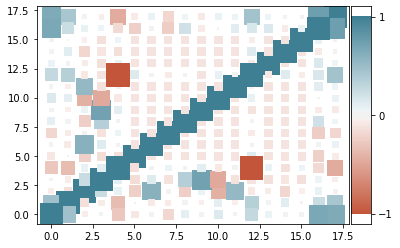

In [ ]:

# Step 1 - Make a scatter plot with square markers, set column names as labels

def heatmap(x, y, size, color):
    fig, ax = plt.subplots()
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])

    n_colors = 256 # Use 256 colors for the diverging color palette
    palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
    color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation
    
    def value_to_color(val):
      val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
      ind = int(val_position * (n_colors - 1)) # target index in the color palette
      return palette[ind]
    
    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x15 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the leftmost 14 columns of the grid for the main plot
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        c=color.apply(value_to_color), # Vector of square colors, mapped to color palette
        marker='s' # Use square as scatterplot marker
        )
    
    # ...
    
    # Add color legend on the right side of the plot
    ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot
    
    col_x = [0]*len(palette) # Fixed x coordinate for the bars
    bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars
    
    bar_height = bar_y[1] - bar_y[0]
    ax.barh(
        y=bar_y,
        width=[5]*len(palette), # Make bars 5 units wide
        left=col_x, # Make bars start at 0
        height=bar_height,
        color=palette,
        linewidth=0
    )
    
    ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
    ax.grid(False) # Hide grid
    ax.set_facecolor('white') # Make background white
    ax.set_xticks([]) # Remove horizontal ticks
    ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
    ax.yaxis.tick_right() # Show vertical ticks on the right 
    
data = df1
columns = ['lat', 'lon', 'bedrooms', 'bathrooms', 'surfacetotal', 'opArmenia', 'opBarranquilla', 'opBello', 'opBogotDC', 'opBucaramanga', 'opCali', 'opCartagena', 'opEnvigado', 'opManizales', 'opMedelln', 'opApartamento', 'opCasa', 'price'] 
corr = data[columns].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs(),
    color = corr['value']
)

In [ ]:
df_train.head(1)

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,l5,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
0,HSOmvzoNx39wqCR/yL57kw==,Propiedad,2018-09-14,2019-09-23,2018-09-14,3.439,-76.541,Colombia,valle del cauca,Cali,NaN,NaN,NaN,12,12,6,202.0,360,20.030119,COP,NaN,Casa En Venta En Cali Miraflores,"Para inversin, actualmente rentando, casa de 4...",Casa,Venta


In [ ]:
df['start_date'] = pd.to_datetime(df.start_date)
df.sort_values(by='start_date')

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,l5,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
29997,L9QVdcgOK302Zb1n13riEw==,Propiedad,2018-09-13,2019-03-03,2018-09-13,3.447000,-76.489000,Colombia,Valle del Cauca,Cali,NaN,NaN,NaN,1.0,1.0,2.0,98.0,98.0,1.500000e+06,COP,Mensual,Local En Arriendo En Cali Base Area,AMPLIO LOCAL EN SECTOR COMERCIAL AL ORIENTE DE...,Casa,Arriendo
30010,h5IrWF+QI+kogteGtNqD1Q==,Propiedad,2018-09-13,2018-09-18,2018-09-13,3.457000,-76.532000,Colombia,Valle del Cauca,Cali,NaN,NaN,NaN,2.0,2.0,2.0,NaN,43.0,1.800000e+08,COP,Mensual,Oficina En Venta En Cali Centenario,Maravillosa Oficina con Dos baos en el noveno ...,Casa,Venta
30011,KymSNOIA35cGaTiJAKf3eQ==,Propiedad,2018-09-13,2018-12-05,2018-09-13,3.421000,-76.490000,Colombia,Valle del Cauca,Cali,NaN,NaN,NaN,2.0,2.0,1.0,45.0,NaN,4.200000e+05,COP,Mensual,Apartamento En Arriendo En Cali Ciudad Crdoba,"APARTAMENTO CUARTO PISO, REA 45 M2, UBICADO EN...",Casa,Arriendo
30012,46SOiy81OXmO86fuxJknTQ==,Propiedad,2018-09-13,2018-11-13,2018-09-13,6.316000,-75.553000,Colombia,Antioquia,Bello,NaN,NaN,NaN,2.0,2.0,2.0,NaN,65.0,8.500000e+05,COP,Mensual,Apartamento En Arriendo En Bello Madera,Arriendo apartamento en Puerta Madera con boni...,Casa,Arriendo
30013,KxnY41ME1Mesoq5a15VEdQ==,Propiedad,2018-09-13,2018-11-13,2018-09-13,10.916000,-74.772000,Colombia,Atlántico,Soledad,NaN,NaN,NaN,2.0,2.0,1.0,55.0,55.0,7.265000e+05,COP,Mensual,Apartamento En Arriendo En Soledad Soledad,APARTAMENTO UBICADO EN CONJUNTO CERRADO - CERC...,Casa,Arriendo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328856,uHikRnae/Sm3aoUqSTFd3A==,Propiedad,2020-01-05,9999-12-31,2020-01-05,4.626063,-74.072620,Colombia,Cundinamarca,Bogotá D.C,Zona Chapinero,Teusaquillo,NaN,3.0,NaN,3.0,117.0,117.0,8.350876e+08,COP,NaN,Propiedad en Venta o Alquiler - Nororiente,Apartamento para estrenar en santa barbara! es...,Local comercial,Venta
328857,0nwq4cyyv1f/2zmptNvpHw==,Propiedad,2020-01-05,9999-12-31,2020-01-05,4.619710,-74.078750,Colombia,Cundinamarca,Bogotá D.C,Zona Centro,Los Mártires,NaN,NaN,NaN,1.0,258.0,258.0,1.290000e+09,COP,NaN,Propiedad en Alquiler - Centro,Estrategias comerciales y de mercadeo tiene el...,Casa,Venta
328849,b1pj1ejc1/XqxDgM4qMTHw==,Propiedad,2020-01-05,2020-02-25,2020-01-05,4.621436,-74.074731,Colombia,Cundinamarca,Bogotá D.C,Zona Chapinero,Teusaquillo,NaN,1.0,NaN,1.0,38.0,38.0,1.100000e+06,COP,NaN,Propiedad en Venta - Centro,Estrategias comerciales y de mercadeo tiene el...,Apartamento,Arriendo
328265,VaL5LKIFoj9KCVVmKxv2Ug==,Propiedad,2020-01-05,9999-12-31,2020-01-05,10.142000,-75.684000,Colombia,Bolívar,Cartagena,NaN,NaN,NaN,NaN,NaN,NaN,50000.0,NaN,1.700000e+09,COP,NaN,Lote En Venta En Cartagena Baru,Lote perfecto para realizar proyecto urbanstic...,Lote,Venta


In [ ]:
df_final = df_train.copy()

In [ ]:
n = 10 #First n most frequent municipalities
series = df_train['l3'].value_counts()[:n]
municipalities = list(series.index)
freq = list(series)

In [ ]:
df_balanced = pd.DataFrame(columns=list(df_train.columns))

In [ ]:
#To make undersampling
n_under = min(freq) #Undersampling min number
df_final = df_train[df_train['l3'].isin(municipalities)]

for x in municipalities:
    temp_df = df_final[df_final['l3'] == x].sample(n = n_under, random_state=4)
    df_balanced = pd.concat([df_balanced, temp_df], ignore_index=True)
    

In [ ]:
df_balanced

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,l5,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
0,21hVd8iuH+Vz8ccVUf91vg==,Propiedad,2019-09-10,2019-12-23,2019-09-10,4.73,-74.045,Colombia,cundinamarca,Bogotá D.C,Zona Norte,Usaquén,Cedritos,3,3,3,75.0,75,19.644456,COP,NaN,Apartamento En Venta En Bogota Cedritos-Usaqun,"Se Vende Apartamento con vista a los cerros, c...",Apartamento,Venta
1,zK8cnFQTvLXcj9GQ9e7/Xw==,Propiedad,2019-06-20,2019-08-01,2019-06-20,4.693,-74.042,Colombia,cundinamarca,Bogotá D.C,Zona Norte,Santa Paula,NaN,3,3,2,115.0,115,20.322788,COP,NaN,Apartamento En Venta En Bogota Santa Paula-Usaqun,"Lindo apartamento de 115 Mts2, con tres alcob...",Apartamento,Venta
2,Q5FuOEN1uZ1L9/eev3nP5Q==,Propiedad,2018-10-30,2018-11-17,2018-10-30,4.589,-74.103,Colombia,cundinamarca,Bogotá D.C,Antonio Nariño,NaN,NaN,5,5,1,92.0,159,18.825479,COP,Mensual,Casa En Venta En Bogota Rafael Uribe Uribe Mar...,"EN SUBASTA PRECIO BASE DE OFERTA, CASA DE 3 NI...",Casa,Venta
3,P6B9tBZmJH0ut0j4LVnWwA==,Propiedad,2019-03-14,2020-01-07,2019-03-14,4.683,-74.05,Colombia,cundinamarca,Bogotá D.C,Zona Chapinero,Chico Reservado,NaN,2,2,3,82.0,82,20.049921,COP,NaN,Apartamento En Venta En Bogota Chico,Al ingresar al apartamento encontramos una zon...,Apartamento,Venta
4,ARHqD42gJbSoaCaOGoy9oA==,Propiedad,2019-03-07,2019-04-10,2019-03-07,4.68718,-74.0341,Colombia,cundinamarca,Bogotá D.C,Usaquén,NaN,NaN,4,NaN,5,260.0,260,21.639557,COP,Mensual,"Apartamento en venta, SANTA ANA ORIENTAL Bogot",La ubicacin exacta de estapropiedad no se publ...,Apartamento,Venta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57715,sLkQ1IZ9293wUm8YmmSxug==,Propiedad,2019-04-26,2019-07-10,2019-04-26,4.53472,-75.8121,Colombia,quindio,Armenia,NaN,NaN,NaN,5,NaN,4,2250.0,400,20.394762,COP,NaN,CHALET EN CONJUNTO CERRADO,Chalet en conjunto cerrado los Yarumos va Arme...,Casa,Venta
57716,sYfcoBCp4Xd1FFQLPfHeFA==,Propiedad,2019-05-23,2019-11-06,2019-05-23,4.50079,-75.6704,Colombia,quindio,Armenia,NaN,NaN,NaN,4,NaN,3,2363.0,450,20.292483,COP,NaN,SE VENDE CASA CAMPESTRE VIA CALARCA - BARCELONA,SE VENDE CASA CAMPESTREVIA CALARCA - BARCELONA...,Casa,Venta
57717,80pJAPoYUE6/GaDGyDLyzg==,Propiedad,2019-07-30,2019-11-06,2019-07-30,4.55816,-75.6576,Colombia,quindio,Armenia,NaN,NaN,NaN,1,NaN,1,37.0,37,18.258162,COP,NaN,Apartaestudio para vender en Armenia Norte,Apartaestudioen venta sector norte consta de1 ...,Apartamento,Venta
57718,wLlsjTVo2SlqeFVLk1CNxw==,Propiedad,2018-11-27,2019-06-08,2018-11-27,4.55397,-75.6602,Colombia,quindio,Armenia,NaN,NaN,NaN,4,NaN,3,192.0,160,19.673444,COP,NaN,Casa en venta en Providencia 1496,CIC. Corporativo Inmobiliario cafetero ofrece ...,Casa,Venta


In [ ]:
df_balanced.drop(columns=['id',"ad_type",'start_date', 'start_date','created_on','end_date',
                 'l1','l2', 'l4','l6', 'l5', 
                 'rooms', 'price_period', 'surface_covered',
                 'operation_type','currency', 'title', 'description'], inplace=True)

In [ ]:
df_train = df_balanced.copy()

## Machine Learning - Initial Model

In [ ]:
X_df = df_train.drop('price', axis=1).copy()
Y_df = df_train['price'].copy()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train_or, X_test_or, Y_train_or, Y_test_or = train_test_split(
    X_df, Y_df, test_size=0.2, random_state=5000)

In [ ]:
# Para eliminar SettingWithCopyWarning

X_train = X_train_or.copy()
X_test = X_test_or.copy()
Y_train = Y_train_or.copy()
Y_test = Y_test_or.copy()

In [ ]:
from sklearn.preprocessing import (PowerTransformer, StandardScaler, 
                                   MinMaxScaler, LabelEncoder, OneHotEncoder)

### Power Transformer Labels (Box-Cox)

Normalize and reduce scale

In [ ]:
box_cox = PowerTransformer(method='box-cox') # Box-Cox object instance
box_cox.fit(X_train["surface_total"].values.reshape(-1,1)) # Box-Cox, array 2 dimensions
X_train.loc[:,"surface_total"] = box_cox.transform(X_train["surface_total"].values.reshape(-1,1)) # Transformamos el array
X_train.head()

,lat,lon,l3,bedrooms,bathrooms,surface_total,property_type
34060,6.16987,-75.5704,Envigado,NaN,3,-0.046900,Apartamento
13423,3.449,-76.549,Cali,3,3,0.497064,Apartamento
47584,6.31997,-75.5681,Bello,NaN,2,-0.659697,Apartamento
34415,6.155,-75.596,Envigado,3,2,-0.747530,Casa
27181,5.053,-75.479,Manizales,3,1,-1.128431,Apartamento


### Standard Scaler
El Standard Scaler sirve para centrar una distribución en 0 y que tenga desviación estándar unitaria.

 $$\mathbf{Z} = \frac{\mathbf{X} - \mathbf{\mu}}{\mathbf{\sigma}}$$


In [ ]:
# Categorical Class
print("Classes: ", X_train['property_type'].unique())
X_train.head()

Classes:  ['Apartamento' 'Casa']


,lat,lon,l3,bedrooms,bathrooms,surface_total,property_type
34060,6.16987,-75.5704,Envigado,NaN,3,-0.046900,Apartamento
13423,3.449,-76.549,Cali,3,3,0.497064,Apartamento
47584,6.31997,-75.5681,Bello,NaN,2,-0.659697,Apartamento
34415,6.155,-75.596,Envigado,3,2,-0.747530,Casa
27181,5.053,-75.479,Manizales,3,1,-1.128431,Apartamento


In [ ]:
le_l3 = LabelEncoder()
le_l3.fit(X_train['l3'])
X_train['l3'] = le_l3.transform(X_train['l3'])

In [ ]:
ohe_l3 = OneHotEncoder()
ohe_l3.fit(X_train["l3"].values[:,None])
out = ohe_l3.transform(X_train["l3"].values[:,None]) 
out_array = out.toarray()
ohe_cols_op = []
for category in ohe_l3.categories_[0]:
    current_class = le_l3.classes_[int(category)]
    col_add = "op_" + current_class
    ohe_cols_op.append(col_add)
    X_train[col_add] = out_array[:,int(category)]

X_train = X_train.drop("l3", axis =1)

In [ ]:
le_proper_type = LabelEncoder()
le_proper_type.fit(X_train['property_type'])
X_train['property_type'] = le_proper_type.transform(X_train['property_type'])

In [ ]:
ohe_proper_type = OneHotEncoder()
ohe_proper_type.fit(X_train["property_type"].values[:,None])
out = ohe_proper_type.transform(X_train["property_type"].values[:,None]) 
out_array = out.toarray()
ohe_cols_op2 = []
for category in ohe_proper_type.categories_[0]:
    current_class = le_proper_type.classes_[int(category)]
    col_add = "op_" + current_class
    ohe_cols_op2.append(col_add)
    X_train[col_add] = out_array[:,int(category)]

X_train = X_train.drop("property_type", axis =1)

### Tratamiento de datos faltantes o NaN

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
# Using Simple Imputer
si_bedrooms = SimpleImputer(strategy='mean')
si_bedrooms.fit(X_train["bedrooms"].values[:,None])
X_train["bedrooms"] = si_bedrooms.transform(X_train["bedrooms"].values[:,None])

si_bedrooms = SimpleImputer(strategy='mean')
si_bedrooms.fit(X_test["bedrooms"].values[:,None])
X_test["bedrooms"] = si_bedrooms.transform(X_test["bedrooms"].values[:,None])

# si_surf = SimpleImputer(strategy='mean')
# si_surf.fit(X_train["surface_total"].values[:,None])
# X_train["surface_total"] = si_surf.transform(X_train["surface_total"].values[:,None])

# si_surf = SimpleImputer(strategy='mean')
# si_surf.fit(X_test["surface_total"].values[:,None])
# X_test["surface_total"] = si_surf.transform(X_test["surface_total"].values[:,None])

si_lat = SimpleImputer(strategy='mean')
si_lat.fit(X_train["lat"].values[:,None])
X_train["lat"] = si_lat.transform(X_train["lat"].values[:,None])

si_lat = SimpleImputer(strategy='mean')
si_lat.fit(X_test["lat"].values[:,None])
X_test["lat"] = si_lat.transform(X_test["lat"].values[:,None])

si_lon = SimpleImputer(strategy='mean')
si_lon.fit(X_train["lon"].values[:,None])
X_train["lon"] = si_lon.transform(X_train["lon"].values[:,None])

si_lon = SimpleImputer(strategy='mean')
si_lon.fit(X_test["lon"].values[:,None])
X_test["lon"] = si_lon.transform(X_test["lon"].values[:,None])

si_bath = SimpleImputer(strategy='mean')
si_bath.fit(X_train["bathrooms"].values[:,None])
X_train["bathrooms"] = si_bath.transform(X_train["bathrooms"].values[:,None])

si_bath = SimpleImputer(strategy='mean')
si_bath.fit(X_test["bathrooms"].values[:,None])
X_test["bathrooms"] = si_bath.transform(X_test["bathrooms"].values[:,None])

In [ ]:
X_test.isna().sum()

lat              0
lon              0
l3               0
bedrooms         0
bathrooms        0
surface_total    0
property_type    0
dtype: int64

In [ ]:
#Otras transformaciones
cols2scale = ['bedrooms', 'bathrooms']
se_cols2scale = StandardScaler()
se_cols2scale.fit(X_train[cols2scale])
X_train[cols2scale] = se_cols2scale.transform(X_train[cols2scale])
X_train.head()

,lat,lon,bedrooms,bathrooms,surface_total,op_Armenia,op_Barranquilla,op_Bello,op_Bogotá D.C,op_Bucaramanga,op_Cali,op_Cartagena,op_Envigado,op_Manizales,op_Medellín,op_Apartamento,op_Casa
34060,6.169865,-75.570410,3.675603e-16,0.399790,-0.046900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
13423,3.449000,-76.549000,-2.547269e-01,0.399790,0.497064,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
47584,6.319971,-75.568084,3.675603e-16,-0.419304,-0.659697,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
34415,6.155000,-75.596000,-2.547269e-01,-0.419304,-0.747530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
27181,5.053000,-75.478996,-2.547269e-01,-1.238397,-1.128431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
X_test['surface_total'] = box_cox.transform(X_test['surface_total'].values[:,None])


In [ ]:
X_test['property_type'] = le_proper_type.transform(X_test['property_type'])

In [ ]:
X_test['l3'] = le_l3.transform(X_test['l3'])

In [ ]:
temp_test = ohe_l3.transform(X_test["l3"].values[:,None]).toarray()
for idx, col in enumerate(ohe_cols_op):
    X_test[col] = temp_test[:,idx]

temp_test = ohe_proper_type.transform(X_test["property_type"].values[:,None]).toarray()

for idx, col in enumerate(ohe_cols_op2):
    X_test[col] = temp_test[:,idx]
    
    


X_test = X_test.drop("property_type", axis=1)
X_test = X_test.drop("l3", axis=1)

In [ ]:
X_test['bedrooms'] = si_bedrooms.transform(X_test["bedrooms"].values[:,None])
X_test['lat'] = si_lat.transform(X_test['lat'].values[:, None])
X_test['lon'] = si_lon.transform(X_test['lon'].values[:, None])
X_test['bathrooms'] = si_bath.transform(X_test['bathrooms'].values[:,None])

In [ ]:
X_test[cols2scale] = se_cols2scale.transform(X_test[cols2scale])

In [ ]:
assert (X_test.columns.values == X_train.columns.values).all()

In [ ]:
X_train

,lat,lon,bedrooms,bathrooms,surface_total,op_Armenia,op_Barranquilla,op_Bello,op_Bogotá D.C,op_Bucaramanga,op_Cali,op_Cartagena,op_Envigado,op_Manizales,op_Medellín,op_Apartamento,op_Casa
34060,6.169865,-75.570410,3.675603e-16,0.399790,-0.046900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
13423,3.449000,-76.549000,-2.547269e-01,0.399790,0.497064,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
47584,6.319971,-75.568084,3.675603e-16,-0.419304,-0.659697,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
34415,6.155000,-75.596000,-2.547269e-01,-0.419304,-0.747530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
27181,5.053000,-75.478996,-2.547269e-01,-1.238397,-1.128431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40067,7.130197,-73.116875,3.675603e-16,0.399790,1.488048,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
52238,6.589991,-75.174546,3.675603e-16,-1.238397,-2.230710,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
30621,6.177000,-75.585999,-1.082399e+00,0.399790,-0.251764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
55905,4.535000,-75.676003,-2.547269e-01,-1.238397,-0.604242,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
#Rename columns
new_col = []

for col in list(X_train.columns):
    new_col.append(clean_alpha(col))
    
    
X_train.columns = new_col
X_test.columns = new_col

In [ ]:
df1 = X_train.copy()

df1['price'] = Y_train.copy()

## Measure of Error of the Models


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# measure error 
def error(Y_test, Y_estimate):
    rmse = mean_squared_error(Y_test, Y_estimate)
    mae = mean_absolute_error(Y_test, Y_estimate)
    r2 = r2_score(Y_test, Y_estimate)
    print("Root Mean Square Error (RMSE)= {:.3f}".format(rmse),
    "\nMean Absolute Error (MAE)= {:.3f}".format(mae),
    "\nR^2 = {:.3f}".format(r2))


In [ ]:
from sklearn.model_selection import cross_val_score
# function to get cross validation scores
def get_cv_scores(model):
    scores = cross_val_score(model,
                             X_train,
                             Y_train,
                             cv=5,
                             scoring='r2')
    
    print('CV Mean: ', np.mean(scores))
    print('STD: ', np.std(scores))
    print('\n')

# Bagging

In [ ]:
import sklearn
from sklearn.ensemble import BaggingRegressor
model1 = sklearn.ensemble.BaggingRegressor(n_estimators=20).fit(X_train, Y_train)

prediction1 = model1.predict(X_test)
error(Y_test, prediction1)

## Bagging with ExtraTree

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor
extra_tree = ExtraTreeRegressor(splitter = "best" ,random_state=1000)
model2 = BaggingRegressor(extra_tree, random_state=1000, n_estimators=60).fit(X_train, Y_train)
prediction2 = model2.predict(X_test)
error(Y_test, prediction2)

In [ ]:
# p = 2**Y_test
# p2 = 2**Y_test_estimate
# mae = mean_absolute_error(p, p2)
# print(mae)

In [ ]:
plt.scatter(Y_test, prediction2)
plt.xlabel(r'$y_{test}$',fontsize=16)
plt.ylabel(r'$y_{pred}$',fontsize=16)
plt.title(r'Precios Reales Vs Predichos',fontsize=16)

## Lasso Regression

In [ ]:
import sklearn
from sklearn.linear_model import  Lasso

model3 = sklearn.linear_model.Lasso(alpha = 0.1).fit(X_train, Y_train)
prediction3 = model3.predict(X_test)
error(Y_test, prediction3)

## LightGBM

In [ ]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, Y_train)
lgb_eval = lgb.Dataset(X_test, Y_test, reference=lgb_train)

params = {
    'boosting_type': 'gbdt','objective': 'regression', 'metric': {'l2', 'l1'},'num_leaves': 31,
    'learning_rate': 0.05, 'feature_fraction': 0.7,'bagging_fraction': 0.8, 'bagging_freq': 5,  'verbose': 0
}

model4 = lgb.train(params,
                lgb_train,
                num_boost_round=6000,
                valid_sets=lgb_eval,
                early_stopping_rounds=10000)

prediction4 = model4.predict(X_test, num_iteration=model4.best_iteration)
error(Y_test, prediction4)

In [ ]:
fig = plt.figure()
plt.scatter(Y_test, prediction4)
plt.xlabel(r'$y_{test}$',fontsize=16)
plt.ylabel(r'$y_{pred}$',fontsize=16)
plt.title(r'Precios Reales Vs Predichos',fontsize=16)
fig.savefig('temp23.png',  dpi=500)

In [ ]:
import plotly.express as px

fig = px.scatter(x=Y_test, y=prediction4)
fig.update_layout(title='Precios Reales Vs Precios Predichos', xaxis_title=  r"$y_{test}$", yaxis_title= r"$y_{pred}$")
fig.show()

### Lasso CV

In [ ]:
from sklearn.linear_model import  LassoCV
model5 = LassoCV().fit(X_train, Y_train)
prediction5 = model5.predict(X_test)
error(Y_test, prediction5)

## Ridge

In [ ]:
from sklearn.linear_model import Ridge
model6 = Ridge(alpha=1).fit(X_train, Y_train)
prediction6 = model6.predict(X_test)
error(Y_test, prediction6)

## Linear

In [ ]:
from sklearn.linear_model import LinearRegression
model7 = LinearRegression().fit(X_train, Y_train)
prediction7 = model7.predict(X_test)
error(Y_test, prediction7)

# Elastic-Net

In [ ]:
from sklearn.linear_model import ElasticNet
model8 = ElasticNet(alpha=1, l1_ratio=0.5).fit(X_train, Y_train)
prediction8 = model8.predict(X_test)
error(Y_test, prediction8)

## XGboost

In [ ]:
import xgboost as xgb
model9 = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.9,
                          learning_rate = 0.9, max_depth = 10, alpha = 30, n_estimators = 30).fit(X_train,Y_train)
prediction9 = model9.predict(X_test)
error(Y_test, prediction9)

# Tuning of Hyperparameters

## Tuning of Ligthlgb

In [ ]:
!pip install optuna

In [ ]:
import numpy as np
import sklearn.datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import optuna.integration.lightgbm as lgb


dtrain = lgb.Dataset(X_train, label=Y_train)
dval = lgb.Dataset(X_test, label=Y_test)

params = {
    "objective": "regression",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
    'metric':  'l2'
}

best_params, tuning_history = dict(), list()

model = lgb.train(
    params,
    dtrain,
    valid_sets=[dtrain, dval],
    best_params=best_params,
    tuning_history=tuning_history,
    verbose_eval=600,
    early_stopping_rounds=100,
)

prediction = model.predict(X_test, num_iteration=model.best_iteration)



In [ ]:
print("Number of finished trials: {}".format(len(tuning_history)))
print("Best params:", best_params)
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))


error(Y_test, prediction)

## Tunning of XGBRegresor

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBRegressor

params = {
        'min_child_weight': [1, 5, 6, 7],
        'gamma': [5, 6, 7, 8, 9],
        'alpha':[50, 100, 150],
        'subsample': [ 0.7, 0.9, 1.0],
        'colsample_bytree': [0.75 ,0.8, 0.9],
        'max_depth': [29, 30, 32],
        'random_state' : np.random.randint(10000, size=20)
        }
xgb = XGBRegressor(learning_rate=0.9, n_estimators=30, objective='reg:squarederror')

skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

random_search_xb = RandomizedSearchCV(xgb, param_distributions=params,
                                   n_iter= 5 , n_jobs=-1,cv = 2, verbose=3)

random_search_xb.fit(X_train, Y_train)


In [ ]:
best_params_xboosts = random_search_xb.best_params_
print('\n Best hyperparameters:',best_params_xboosts)

In [ ]:
ypred = random_search_xb.predict(X_test)
error(Y_test, ypred)

## Tuning ExtraTrees

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
params = {
        'max_depth': [29, 30, 32],
        'random_state' : np.random.randint(10000, size=20),
        'max_features' : ['auto', 'sqrt', 'log2'],
        }
extr = ExtraTreeRegressor(splitter='best')

skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

random_search_et = RandomizedSearchCV(extr, param_distributions=params,
                                   n_iter= 5 , n_jobs=-1,cv = 2, verbose=3)

random_search_et.fit(X_train, Y_train)


In [ ]:
best_params_et = random_search_et.best_params_
print('\n Best hyperparameters:',best_params_et)

In [ ]:
ypred = random_search_et.predict(X_test)
error(Y_test, ypred)

### Tuning BaggingRegresor

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
params = {
        'random_state' : np.random.randint(10000, size=20),
        'n_estimators' : np.random.randint(100, size=20),
        }
reg = BaggingRegressor()

skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

random_search_b = RandomizedSearchCV(reg, param_distributions=params,
                                   n_iter= 1 ,cv = 2,  n_jobs=-1, verbose=3)

random_search_b.fit(X_train, Y_train)


In [ ]:
best_params_b = random_search_b.best_params_
print('\n Best hyperparameters:',best_params_b)

In [ ]:
ypred = random_search_b.predict(X_test)
error(Y_test, ypred)

# Mixing of Best Models 

###  mixing xboost and bagging

In [ ]:
bes_xgb = XGBRegressor(subsample = 0.9, random_state = 3061,
                       min_child_weight = 7, max_depth =  32,
                       gamma =  7,colsample_bytree = 0.8,
                       alpha = 150, learning_rate=0.9, 
                       n_estimators=30)#, objective='reg:squarederror')
baaggin = BaggingRegressor(base_estimator=bes_xgb, random_state = 5627, n_estimators = 10)
baaggin.fit(X_train, Y_train)

In [ ]:
ypred = baaggin.predict(X_test)
error(Y_test, ypred)

### mixing bagging and extra_tree 

In [ ]:
best_extr = ExtraTreeRegressor(random_state = 9502, max_features = 'log2', max_depth = 30, splitter='best')
baaggin2 = BaggingRegressor(base_estimator=best_extr, random_state = 5627, n_estimators = 10)
baaggin2.fit(X_train, Y_train)

In [ ]:
ypred = baaggin2.predict(X_test)
error(Y_test, ypred)

# Plots

In [ ]:
import plotly
from plotly.offline import init_notebook_mode, plot, iplot, download_plotlyjs

import plotly.graph_objs as go
import plotly.figure_factory as ff

In [ ]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [ ]:
#Sin log
configure_plotly_browser_state()
init_notebook_mode(connected = False)

fig = ff.create_distplot([df_train.price.astype(float)], ['Price'], show_hist = False)
fig.show()

In [ ]:
#Con log
configure_plotly_browser_state()
init_notebook_mode(connected = False)

fig = ff.create_distplot([df_train.price.apply(lambda x: np.log(x)).astype(float)], ['Price'], show_hist = False)
fig.show()